# Read the preprocessed Data

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
df=pd.read_csv("../../Data/ml-latest-small/PreprocessedData_ml_latest_year_small.csv",index_col=0)
df.head()

,userId,movieId,rating,title,genres,year
0,1,1,4.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,5,1,4.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
2,7,1,4.5,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
3,15,1,2.5,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
4,17,1,4.5,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995


# Further Processing the Data (optional)

## Genre management

In [2]:
#genres = df_prelim.genres.str.get_dummies(sep = "|")

#df = pd.concat([df_prelim, genres], axis=1)
#df = df.drop(['genres'], axis = 1)
#df.head()

# Collaborative Filtering (CF)

The Collaborative Filtering Recommender is entirely based on the past behavior and not on the context.

## 0. User Input

In [3]:
def AskForUserInput():
    fav_movie = input('Enter your Facourite Movie: ')
    n= 0
    movies=df['title'].unique()
    while fav_movie not in movies and n<5:# maximum 5 prompts
        print("The Movie ", fav_movie, "does not exist in our database.") 
        fav_movie = input('Please enter another Facourite Movie: ')
        n +=1
    return fav_movie

## 1.  Model 1: Memory Based Approach, Item-Item Collaborative Filtering, N Neighbours

**This is NOT a Machine Learning Model**

> Memory Based Collaborative Filtering:
>
> Take a matrix of preferences for items by users using this matrix 
> to predict missing preferences and recommend items
> There are two types of memory based models:
>> 1) Item-Item Collaborative Filtering: “Users who liked this item also liked …”
>>
>> (i.e. starting from a given movie (or set of movies) we find similar movies based on other users’ preferences.)
>>
>> 2) User-Item Collaborative Filtering: “Users who are similar to you also liked …”
>>
>> (i.e. find users that have seen/rated similar content, and use their preferences to recommend new items)
>
> Memory Based Filtering Pros:
>> 1) Easy to implement
>>
>> 2) produce reasonable prediction quality
>
>Cons:
>> 1) It tends to recommend popular items.
>> 2) It suffers when new items that don’t have any ratings enter the system.

### 1. Create a Pivot Matrix using only the train data

We pivot the dataframe to have userId as rows and movieId as columns. 

We do not specify a special feature. We consider all features (rating, dummitized genres and year)

In [4]:
df_movie_pivot = df.pivot(
    index='movieId',
    columns='userId',
    values='rating'
).fillna(0)
df_movie_pivot.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2.  Sparse matrix

A lot of values n the above matrix are zero, i.e. the data is extremely sparse.

> A sparse matrix is a matrix that is comprised of mostly zero values.

> Convert into an Array Matrix by using csr_matrix


In [5]:
from scipy.sparse import csr_matrix
feature_matrix=csr_matrix(df_movie_pivot.values)

### 3. Build the Model

In [6]:
from sklearn.neighbors import NearestNeighbors
#We only consider 10 nearest neighbours
n_neigh=10
model_knn_rating=NearestNeighbors(metric="cosine",n_neighbors=n_neigh)
model_knn_rating.fit(feature_matrix)

NearestNeighbors(metric='cosine', n_neighbors=10)

### 4. Create The Function to recommend movies

In [7]:
def recommend_movie_by_rating(query_title):
    
    #Find the movie ID w.r.t the the title
    query_index=df[df['title']==query_title]['movieId'].unique()[0]
    
    distances,indices=model_knn_rating.kneighbors(
        df_movie_pivot.iloc[query_index,:].values.reshape(1,-1)
    )
    
    MovieIds=[]
    CosDistance=[]
    ratedBy=[]
    
    for i in range(0,len(distances.flatten())):
        movieId=df_movie_pivot.index[indices.flatten()[i]]
        MovieIds.append(movieId)
    
        CosDistance.append(distances.flatten()[i])
        ratedBy.append(len(df[df['movieId']==movieId]['rating']))
        
    df_out=df[df.movieId.isin(MovieIds)].drop(["userId"],axis=1)
    
    df_out=df_out.groupby(['movieId','title',"year","genres"]).mean()
    df_out['average rating']=df_out['rating'].round(2)
    df_out=df_out.drop(['rating'],axis=1)
    df_out['number of ratings']=ratedBy
    df_out['Cosine Distance, ML Model']=CosDistance
    df_out['Cosine Distance, ML Model']=df_out['Cosine Distance, ML Model'].round(2)
    print("Because You like the movie",query_title,"we'd recommend you to watch:")
    display(df_out.head(10))

    #Results are automatically sorted as in the pivot table the indices are the movie ids

### 5. Test 

In [8]:
input_movie=AskForUserInput()
recommend_movie_by_rating(input_movie)

Enter your Facourite Movie: Jumanji
Because You like the movie Jumanji we'd recommend you to watch:


,,,,average rating,number of ratings,"Cosine Distance, ML Model"
movieId,title,year,genres,,,
3,Grumpier Old Men,1995,Comedy|Romance,3.26,52,0.00
5,Father of the Bride Part II,1995,Comedy,3.07,29,0.55
7,Sabrina,1995,Comedy|Romance,3.19,41,0.55
65,Bio-Dome,1996,Comedy,2.53,82,0.55
95,Broken Arrow,1996,Action|Adventure|Thriller,3.02,123,0.56
708,"Truth About Cats & Dogs, The",1996,Comedy|Romance,3.39,49,0.58
736,Twister,1996,Action|Adventure|Romance|Thriller,3.32,84,0.59
762,Striptease,1996,Comedy|Crime,2.41,31,0.59
788,"Nutty Professor, The",1996,Comedy|Fantasy|Romance|Sci-Fi,2.73,58,0.60


### 6. Save Your Model

In [9]:
import pickle
filename = 'Model_1_NearestNeighbours_ratingbased.sav'
pickle.dump(model_knn_rating, open(filename, 'wb'))

## 2. Model 2: Model-based Collaborative Filtering, user-based, K-means

In this approach, CF models are developed using **machine learning algorithms** to predict user’s rating of unrated items. 

> We will use **Surprise**
>> Surprise is a Python scikit for building and analyzing recommender systems that deal with explicit rating data.



### 1. Load Surprise Data from DataFrame, Train-Test Split

In [10]:
from surprise import accuracy
from surprise.dataset import Dataset
from surprise.reader import Reader
from surprise.model_selection import train_test_split,cross_validate,RandomizedSearchCV
from surprise import KNNWithMeans
from surprise import KNNBasic
reader = Reader()

#delete unnecessary columns away
df_imp=df.drop(['title','year','genres'],axis=1)

surprise_data = Dataset.load_from_df(df_imp, reader)
trainset, testset = train_test_split(surprise_data, test_size=.25,random_state=10)

In [11]:
def find_best_model(model, parameters,data):
    clf = RandomizedSearchCV(model, parameters, n_jobs=-1, measures=['rmse'])
    clf.fit(data)             
    print(clf.best_score)
    print(clf.best_params)
    print(clf.best_estimator)
    return clf

### 2. Find Optimal k using RandomizedSearchCV

In [12]:
sim_options = {
    "name": ["msd", "cosine", "pearson", "pearson_baseline"],"user_based": [True]
}
params = { 'k': range(2,25,1),'sim_options': sim_options}
clf = find_best_model(KNNWithMeans, params, surprise_data)

{'rmse': 0.8935133061779613}
{'rmse': {'k': 21, 'sim_options': {'name': 'pearson_baseline', 'user_based': True}}}
{'rmse': <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x7fa76a80f190>}


### 3. Build Model using best parameters

In [13]:
knnwithmeans = clf.best_estimator['rmse']

### Recommender System Class
(Inspired from https://www.kaggle.com/code/rangarajansaranathan/collaborative-filtering-based-recommender-system)


In [29]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        #cross-relate other information from the fulldf
        movieName=df[df['movieId']==iid]['title'].unique()[0]
        movieYear=df[df['movieId']==iid]['year'].unique()[0]
        genres=df[df['movieId']==iid]['genres'].unique()[0]
        avgRat=df[df['movieId']==iid]['rating'].mean().round(2)
        ratedBy=len(df[df['movieId']==iid]['rating'])
        
        top_n[uid].append((iid, movieName, movieYear, genres, avgRat, ratedBy))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

def rated_already(uid):
    df_out=df[df['userId']==uid]
    return df_out.title.unique()
    
class collab_filtering_Kmeans_Model():
    def __init__(self, model, trainset, testset, fulldf, data):
        self.model = model
        self.trainset = trainset
        self.testset = testset
        self.data = data
        self.pred_test = None
        self.recommendations = None
        self.top_n = None
        self.recommenddf = None

    def fit_and_predict(self):        
        print('**Fitting the train data...**')
        self.model.fit(self.trainset)       

        print('**Predicting the test data...**')
        self.pred_test = self.model.test(self.testset)        
        rmse = round(accuracy.rmse(self.pred_test), 3)
        print('**RMSE for the predicted result is ' + str(rmse) + '**')   
        
        #display(self.pred_test)
        self.top_n = get_top_n(self.pred_test)
      
        self.recommenddf = pd.DataFrame(columns=['userId', 'movieId', 'title', 'year', 'genres', 'average rating','number of ratings'])
        
        for item in self.top_n:
            subdf = pd.DataFrame(self.top_n[item], columns=['movieId','title',  'year', 'genres', 'average rating','number of ratings'])
            subdf['userId'] = item
            
            cols = subdf.columns.tolist()
            cols = cols[-1:] + cols[:-1]
            subdf = subdf[cols]        
            self.recommenddf = pd.concat([self.recommenddf, subdf], axis = 0)        
        return rmse
        
    def cross_validate(self):
        print('**Cross Validating the data...**')
        cv_result = cross_validate(self.model, self.data, n_jobs=-1,cv=5,verbose = True)
        
        return cv_result

    def recommend_foruser(self, user_id, n=5):
        List_already=rated_already(user_id)
        print('The User ',user_id,"has already rated", len(List_already),"other movies.")
        #print(List_already)
        
        print('Recommending top ',n,' movies for userid ',user_id,':')
        df_out = self.recommenddf[self.recommenddf.userId == user_id].head(n)
        
        #Just to ensure that you are not recommending something already rated by the user
        #common=list(set(List_already).intersection(df.title))
        #print("Common movies:", common)
        #One thing I do not understand how the model knows to recommend  movies not already rated?
        return df_out
    
    def recommend_similar_items(self,movie_title,n=5):
        movieId=df[df['title']==movie_title]['movieId'].unique()[0]
        movie_neighbours=self.model.get_neighbors(movieId,n)
        
        df_out=df[df.movieId.isin(movie_neighbours)].drop(["userId"],axis=1)
        df_out=df_out.groupby(['movieId','title',"year","genres"]).mean()
        df_out['average rating']=df_out['rating'].round(2)
        df_out=df_out.drop(['rating'],axis=1)
        df_out['number of ratings']=len(df[df.movieId.isin(movie_neighbours)]['rating'])
        
        return df_out 

In [31]:
CF_knnwithmeans = collab_filtering_Kmeans_Model(knnwithmeans, trainset, testset, df, surprise_data)

### 5. Fit, predict and cross-validate

In [32]:
knnwithmeans_rmse=CF_knnwithmeans.fit_and_predict()

**Fitting the train data...**
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
**Predicting the test data...**
RMSE: 0.9006
**RMSE for the predicted result is 0.901**
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [33]:
knnwithmeans_cv_rmse_cv = CF_knnwithmeans.cross_validate()
mean_cv_RMSE_result = round(knnwithmeans_cv_rmse_cv['test_rmse'].mean(),3)
print('**Mean CV RMSE is ' + str(mean_cv_RMSE_result)  + '**')

**Cross Validating the data...**
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8989  0.8903  0.8964  0.8865  0.9057  0.8956  0.0067  
MAE (testset)     0.6809  0.6774  0.6802  0.6728  0.6823  0.6787  0.0034  
Fit time          0.15    0.17    0.20    0.19    0.20    0.18    0.02    
Test time         1.18    1.19    1.14    1.08    1.03    1.12    0.06    
**Mean CV RMSE is 0.896**


### Model Errors Plot

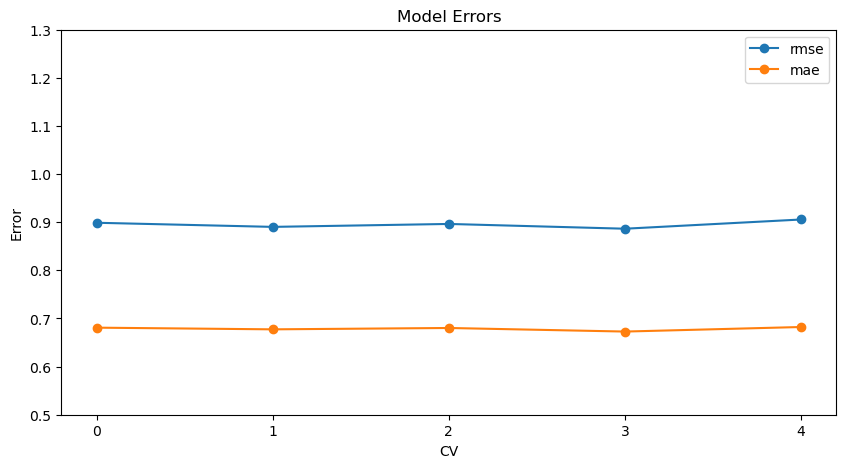

In [34]:
# Get data
rmse = knnwithmeans_cv_rmse_cv['test_rmse']
mae = knnwithmeans_cv_rmse_cv['test_mae']
x = np.arange(len(rmse))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize = (10, 5))
plt.xticks(np.arange(min(x), max(x) + 1, 1.0))
plt.ylim(0.5, 1.3)
ax.plot(x, rmse, marker='o', label="rmse")
ax.plot(x, mae, marker='o', label="mae")

# Chart setup
plt.title("Model Errors", fontsize = 12)
plt.xlabel("CV", fontsize = 10)
plt.ylabel("Error", fontsize = 10)
plt.legend()
plt.show()


### 6. Recommend (User based)

In [35]:
def AskForUserInput_userId():
    inp_id = int(input('Enter your UserId: '))
    n= 0
    
    while inp_id not in df.userId.unique() and n<5:# maximum 5 prompts
        print("The UserId ", inp_id, "does not exist in the database.") 
        inp_id = input('Please enter UserId: ')
        n +=1
    return inp_id

inp_id=AskForUserInput_userId()
result_knn_user1 = CF_knnwithmeans.recommend_foruser(user_id=inp_id, n=10)
display(result_knn_user1)

Enter your UserId: 45
The User  45 has already rated 397 other movies.
Recommending top  10  movies for userid  45 :


,userId,movieId,title,year,genres,average rating,number of ratings
0,45,1934,You Can't Take It with You,1938,Comedy|Romance,3.83,3
1,45,3387,Who's Harry Crumb?,1989,Comedy|Mystery,2.86,7
2,45,2987,Who Framed Roger Rabbit?,1988,Adventure|Animation|Children|Comedy|Crime|Fant...,3.57,97
3,45,3565,Where the Heart Is,2000,Comedy|Drama,3.50,7
4,45,7294,Welcome to Mooseport,2004,Comedy,3.25,4
5,45,3385,Volunteers,1985,Comedy,2.81,8
6,45,903,Vertigo,1958,Drama|Mystery|Romance|Thriller,4.03,60
7,45,32,Twelve Monkeys,1995,Mystery|Sci-Fi|Thriller,3.98,177
8,45,380,True Lies,1994,Action|Adventure|Comedy|Romance|Thriller,3.50,178
9,45,4034,Traffic,2000,Crime|Drama|Thriller,3.90,70


### 7. Recommend (Item Based)

In [37]:
inp_movie=AskForUserInput()
df_out=CF_knnwithmeans.recommend_similar_items(inp_movie, n=10)
print("Because You like the movie",inp_movie,"we'd recommend you to watch:")
display(df_out.head(10))

Enter your Facourite Movie: Jumanji
Because You like the movie Jumanji we'd recommend you to watch:


,,,,average rating,number of ratings
movieId,title,year,genres,,
13,Balto,1995,Adventure|Animation|Children,3.12,471
16,Casino,1995,Crime|Drama,3.93,471
17,Sense and Sensibility,1995,Drama|Romance,3.78,471
36,Dead Man Walking,1995,Crime|Drama,3.84,471
60,"Indian in the Cupboard, The",1995,Adventure|Children|Fantasy,3.24,471
76,Screamers,1995,Action|Sci-Fi|Thriller,3.40,471
137,Man of the Year,1995,Documentary,3.00,471
242,Farinelli: il castrato,1994,Drama|Musical,3.60,471
352,Crooklyn,1994,Comedy|Drama,2.50,471


### 7. Save Your Model

In [38]:
import pickle
filename = 'Model_2_KNN_Means_ratingbased.sav'
pickle.dump(CF_knnwithmeans, open(filename, 'wb'))